In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, rc
import os 

%matplotlib inline
# %matplotlib notebook
# from ipywidgets import interactive, interact

# Add latex fonts if availabe (may need to change path of latex install)
if os.path.isdir("/usr/local/texlive/2020/bin"):
    os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2020/bin/x86_64-darwin'
    rc('text', usetex='True')
    rc('font', family='serif', serif = 'Helvetica')
    params= {'text.latex.preamble' : [r'\usepackage{amsfonts}']}
    plt.rcParams.update(params)
    
if not os.path.exists('./plots'):
    os.makedirs('./plots')

/opt/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


Consider a charging facility offering $L$ service levels where the total cost to a user from choosing a service level $\ell$ is 
$$g_\ell(x_j, \alpha_j) = x_j V^\ell + \alpha_j \frac{x_j}{R^\ell}.$$

where $x_j \sim f_X(x_j)$ and $\alpha_j \sim p_A(\alpha_j; p,a)$. We are interested in the quantity $$ \mathbb{E}[\eta(t);p,a] = \lambda \mathbb{E}[x] \mathbb{E}[\frac{1}{r};p,a]$$ and its sensitivity to the mischaracterization of $\alpha_j$. 

In the next block, for each service level $\ell \in \{1, \dots, L\}$ we must set the charging rates and their prices. Additionally, we set $f_X(x_j) = \mathcal{U}(x_\text{min}, x_\text{max})$ and compute $\mathbb{E}[x]$. 


In [49]:
lambda_val = 30 # EVs/ hr
x_min = 5
x_max = 100
E_x = (x_max**2 - x_min**2)/(2 * (x_max - x_min)) #expected value of demand x_j (kwh)
R_ell_A = np.array([15, 30 , 35])
V_ell_A = np.array([.15, .25, .32])

R_ell_B = np.array([15, 30 , 35])
V_ell_B = np.array([.05, .25, .33])

Next, we build a matrix that gives the ratio $$\frac{\Delta^i_k V}{\Delta^k_i \bar{R}} $$ 
where $\Delta^i_k V = V^i - V^k$, and $\Delta^k_i \bar{R} = \frac{1}{R^k} - \frac{1}{R^i}$. This ratio is important for finding probability a user will choose a specific charging rate. Specifically, the PMF of the charge rates 
$$\renewcommand{\P}{\mathbb{P}}
p_{r}(r) = 
        \begin{cases}       
            \P \left(\underline{\alpha}^1 < \alpha_j < \bar{\alpha}^1 \right) & \text{if } r = R^1 \,, \\ 
            \qquad \quad  \vdots &  \\
            \P \left(\underline{\alpha}^L < \alpha_j < \bar{\alpha}^L \right) & \text{if } r = R^L \,.
        \end{cases} 
$$
where $\underline{\alpha}^1 = -\infty$ and $\bar{\alpha}^L = +\infty$ and otherwise $$\underline{\alpha}^k =  \max_{i<k}\frac{\Delta^i_k V}{\Delta^k_i \bar{R}} $$ and $$ \bar{\alpha}^k = \min_{k < i}\frac{\Delta^i_k V}{\Delta^k_i \bar{R}}.$$ The next block prints out the ratio mentioned above in matrix format where each row is $k$ and each column is the index $i$. 

In [50]:
# Compute Delta Ratio 
def compute_delVdelR(R_ell, V_ell):
    delR = np.vstack((R_ell, R_ell))
    delV = np.vstack((V_ell, V_ell))

    for _ in range(0, R_ell.size - 2):
        delR = np.vstack((delR, R_ell))
        delV = np.vstack((delV, V_ell))

    delR = delR.astype('float')
    delR[delR==0] = np.nan

    delR = np.divide(1,delR) - np.divide(1, delR.T) 
    delV = delV.T - delV

    # print(delR, '\n', delV)
    delVdelR = np.divide(delV, delR)
    
    return delVdelR

delVdelR_A = compute_delVdelR(R_ell_A, V_ell_A)
delVdelR_B = compute_delVdelR(R_ell_B, V_ell_B)

print("The ratio matrix where the row is k and the column is i is: \n", delVdelR_A)
print("The ratio matrix where the row is k and the column is i is: \n", delVdelR_B)

The ratio matrix where the row is k and the column is i is: 
 [[    nan  3.      4.4625]
 [ 3.         nan 14.7   ]
 [ 4.4625 14.7        nan]]
The ratio matrix where the row is k and the column is i is: 
 [[  nan  6.    7.35]
 [ 6.     nan 16.8 ]
 [ 7.35 16.8    nan]]


<ipython-input-50-86f0c3dd1d3c>:17: RuntimeWarning: invalid value encountered in true_divide
  delVdelR = np.divide(delV, delR)


In [51]:
def prob_choice(delVdelR, alpha_pmf_val, alpha_pmf_wt):
    # Get min and max values
    alpha_min = np.min(alpha_pmf_val)
    alpha_max = np.max(alpha_pmf_val)
    prob_choosing_R = np.zeros((delVdelR.shape[0],1))
    for i in range(0, R_ell_A.size):
        if i == 0:
            lower = alpha_min
            upper = np.nanmin(delVdelR[i+1:])
#             print(lower, "\t", upper)
        elif i == R_ell_A.size - 1:
            lower = np.nanmax(delVdelR[:i])
            upper = alpha_max
#             print(lower, "\t", upper)
        else:
            lower = np.maximum(alpha_min, np.nanmax(delVdelR[i][:i]))
            upper = np.minimum(alpha_max, np.nanmin(delVdelR[i][i+1:]))
            
#         print(lower, "\t\t\t",upper)
        idx = (alpha_pmf_val >= lower) & (alpha_pmf_val <= upper)
    #     print(np.where(idx)[0])
        idx = np.where(idx)
        if idx[0].size > 0:
#             print("size", idx[0].size)
            for j in range(0, idx[0].size):
                prob_choosing_R[i] += alpha_pmf_wt[idx[0][j]]
    return prob_choosing_R

In [52]:
def compute_exp_1_r(prob_choosing_R):
    E_1_r = 0
    for i in range(0, R_ell_A.size):
        E_1_r += prob_choosing_R[i] * (1/R_ell[i])
    
    return E_1_r

In [53]:
# PMF of alpha 
alpha_pmf_val = np.array([2,10,20,25]) # a vector
alpha_pmf_wt = np.array([0.25,0.25,0.25,0.25]) # p vector

In [54]:
alpha_vals = np.arange(2.0,20,0.05)

prob_vec_A = []
for a2 in alpha_vals:
    prob_vec_A.append(prob_choice(delVdelR_A, [2, a2,20,25], alpha_pmf_wt))

prob_vec_B = []
for a2 in alpha_vals:
    prob_vec_B.append(prob_choice(delVdelR_B, [2, a2,20,25], alpha_pmf_wt))

# print(prob_vec)

In [55]:
E_eta_A=[]
for probs in prob_vec_A:
    E_1_r_temp=0;
    for i in range(0, R_ell_A.size):
        E_1_r_temp += probs[i] * (1/R_ell_A[i])
    E_eta_temp= lambda_val*E_x*E_1_r_temp
    E_eta_A.append(E_eta_temp)

E_eta_B=[]
for probs in prob_vec_B:
    E_1_r_temp=0;
    for i in range(0, R_ell_A.size):
        E_1_r_temp += probs[i] * (1/R_ell_B[i])
    E_eta_temp= lambda_val*E_x*E_1_r_temp
    E_eta_B.append(E_eta_temp)
    
E_eta_A=np.array(E_eta_A)
E_eta_B=np.array(E_eta_B)

<IPython.core.display.Javascript object>


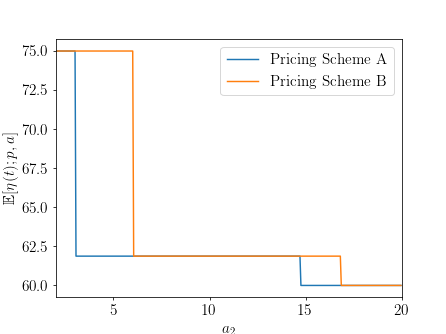

In [62]:
%matplotlib notebook
fig = plt.figure()
ax = fig.subplots(1, 1)
ax.plot(alpha_vals,E_eta_A, label=r'Pricing Scheme A')
ax.plot(alpha_vals,E_eta_B, label=r'Pricing Scheme B')
# ax.hlines(61.875, 2,20, linestyle='--', color='red',label=r'$\mathbb{E}[\eta(t)]$')
# ax.hlines(75.0, 2,20, linestyle='--', color='red',label=r'$\mathbb{E}[\eta(t)]$')
ax.legend()
# ax.plot_trisurf(E_etaa[:,0],E_etaa[:,1],)
ax.set_xlim([2, 20])

ax.set_xlabel(r'$a_2$')
ax.set_ylabel(r'$\mathbb{E}[\eta(t); p,a]$')
# ax.set_zlabel(r'$\mathbb{E}[\eta(t); p,a]$')
# ax.set_title(r'$[p_{low},p_{high}]=[%2.1f, %2.1f]$' % (alpha_pmf_wt[0],alpha_pmf_wt[1]))

plt.rcParams.update({'font.size': 16})    
plt.show()
# fig.savefig("./plots/theorem_grad_a.pdf", bbox_inches='tight')
np.savetxt("E_A.txt", np.c_[alpha_vals, E_eta_A]) 
np.savetxt("E_B.txt", np.c_[alpha_vals, E_eta_B]) 
